In [1]:
import os
import pandas as pd
import numpy as np

from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier

from yellowbrick.classifier import ClassificationReport

/home/julien/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
%matplotlib inline
pd.set_option('display.max_columns', 55)

In [3]:
#read in csv
df = pd.read_csv("bigtable.csv")

In [4]:
dict(df.dtypes)

{'datetime': dtype('O'),
 'pm25': dtype('float64'),
 'type': dtype('O'),
 'sensor': dtype('O'),
 'station_id': dtype('O'),
 'x': dtype('float64'),
 'y': dtype('float64'),
 'population': dtype('float64'),
 'dist-mroads': dtype('float64'),
 'dist-setl': dtype('float64'),
 'dist-coast': dtype('float64'),
 'dist-forest': dtype('float64'),
 'slope': dtype('float64'),
 'elevation': dtype('float64'),
 'dayofweek': dtype('int64'),
 'sin_day': dtype('float64'),
 'cos_day': dtype('float64'),
 'sin_year': dtype('float64'),
 'cos_year': dtype('float64'),
 'TEMP': dtype('float64'),
 'WIND': dtype('float64'),
 'DEW': dtype('float64'),
 'SKY': dtype('float64'),
 'VIS': dtype('float64'),
 'ATM': dtype('float64'),
 'AQI_class': dtype('O'),
 'AQI_VALUE': dtype('float64')}

In [5]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep]#.astype(np.float64)

df = clean_dataset(df).reset_index()

features = df[[
    'population', 
    'dist-mroads', 
    'dist-setl', 
    'dist-coast', 
    'dist-forest', 
    'slope', 
    'elevation', 
    'dayofweek', 
    'sin_day', 
    'cos_day',
    'sin_year', 
    'cos_year', 
#    'TEMP', 
#    'WIND', 
#    'DEW', 
#    'SKY', 
#    'VIS', 
#    'ATM'
]]

labels = df[[
    'pm25',
    'AQI_VALUE', #pm25 transformed using EPA methodology
    'AQI_class'  #pm25 transformed into EPA categorical class
]]

labels["polluted"] = (labels["AQI_class"] != "Good")

y=labels["polluted"]
X=features

/home/julien/.local/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


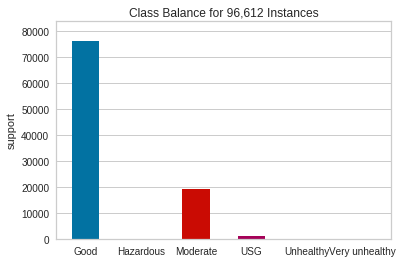

In [6]:
from yellowbrick.target import ClassBalance

# Instantiate the visualizer
visualizer = ClassBalance(
    #labels=["Good", "USG", "Moderate", "Unhealthy", "Very unhealthy", "Hazardous"], size=(1080, 720)
)

visualizer.fit(df['AQI_class'].values)
visualizer.show()

In [7]:
df['AQI_class'].value_counts


<bound method IndexOpsMixin.value_counts of 0         USG
1         USG
2        Good
3        Good
4        Good
         ... 
96607    Good
96608    Good
96609    Good
96610    Good
96611    Good
Name: AQI_class, Length: 96612, dtype: object>

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder


In [9]:
def score_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """ 
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
         ('one_hot_encoder', OneHotEncoder()), 
         ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    model.fit(X, y, **kwargs)  
    
    expected  = y
    predicted = model.predict(X)
    
    # Compute and return F1 (harmonic mean of precision and recall)
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted)))

In [10]:
# Try them all!

models = [
    #SVC(gamma='auto'), NuSVC(gamma='auto'), LinearSVC(), 
    #SGDClassifier(max_iter=100, tol=1e-3), KNeighborsClassifier(), 
    LogisticRegression(solver='lbfgs'), #LogisticRegressionCV(cv=3), 
    BaggingClassifier(), ExtraTreesClassifier(n_estimators=100), 
    RandomForestClassifier(n_estimators=100)
]


for model in models:
    score_model(X, y, model)

/home/julien/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression: 0.6654739623472421
BaggingClassifier: 0.9431319776714513
ExtraTreesClassifier: 0.9478863902911632
RandomForestClassifier: 0.949041887817398


/home/julien/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/home/julien/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


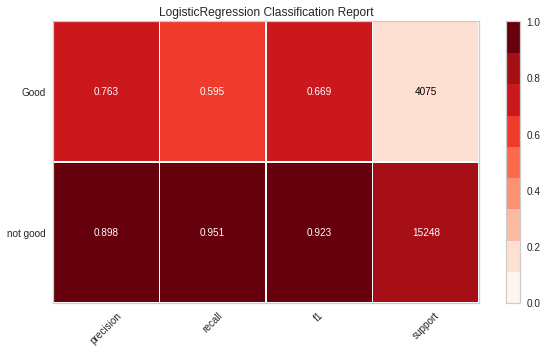

/home/julien/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


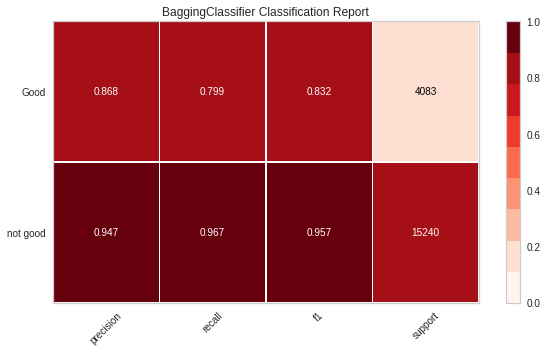

/home/julien/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


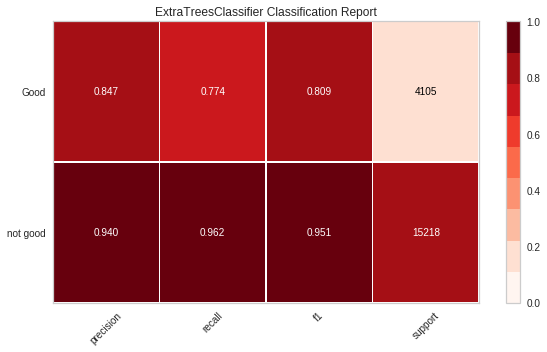

/home/julien/.local/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


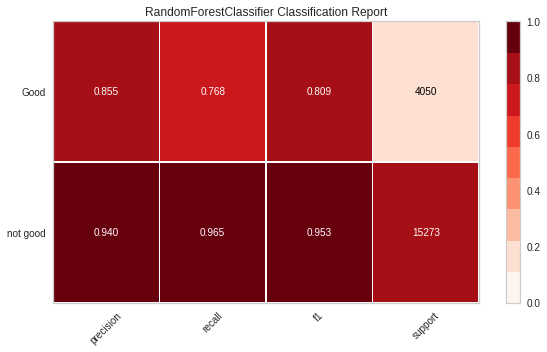

In [12]:
def visualize_model(X, y, estimator):
    """
    Test various estimators.
    """ 
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
         ('one_hot_encoder', OneHotEncoder()), 
         ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, 
        classes=['not good', 'Good'], 
        cmap="Reds", 
        support=True,
        size=(600, 360)
    )
    
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.20)
    
    visualizer.fit(X_train, y_train)  
    visualizer.score(X_test, y_test)
    visualizer.show()  

for model in models:
    visualize_model(X, y, model)